Notebook to querry GALEX field and visit information

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.table import unique, Table
from astropy import units as uu
from astropy.coordinates import SkyCoord
import healpy as hpy
import numpy as np
from vasca.resource_manager import ResourceManager

Get field info from astroquery

In [7]:
#Get TDS field info
tt_tds = Table.read("./TDS-ApJ_766_60/tds_fields_table2.ecsv")
dd_query = {"instrument_name":"GALEX",
             "dataproduct_type":"image",
             "dataRights":"PUBLIC",
             "filters":"NUV",
             "radius":".02 deg",
             "target_name":tt_tds["name"]}
# "coordinates":tt_tds["coordinates"]

tt_obs = Observations.query_criteria(**dd_query)
#tt_obs["obs_id","target_name"].pprint(100)
tt_obs[0:2].show_in_notebook()

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,image,2,GALEX,2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,54791.262777777774,55512.31023148148,40457.25,UV,NUV,169300000000.0,300700000000.0,--,--,55953.94460633,GALEX,--,--,DIS,DIS,--,DIS,CIRCLE ICRS 35.57886335 -3.14176421 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS00-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/PS_XMMLSS_MOS00-nd-exp.fits.gz,PUBLIC,--,5885.0,science,2047,3659
1,image,2,GALEX,2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,54791.33122685185,55512.37857638889,38609.0,UV,NUV,169300000000.0,300700000000.0,--,--,55953.94680547,GALEX,--,--,DIS,DIS,--,DIS,CIRCLE ICRS 36.49984982 -3.49231255 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS01-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/PS_XMMLSS_MOS01-nd-exp.fits.gz,PUBLIC,--,5885.0,science,2048,3661


Get all-sky visit information

In [8]:
#Get data and add healpix info
rm = ResourceManager()
tt_vis = Table.read(rm.get_path("gal_visits_list", "sas_cloud"))
cosys     = "G" #"Q" for equatorial, "G" for galactic
nside     = 256
npix      = hpy.nside2npix(nside)
tt_vis["hpix"] = hpy.ang2pix(nside,tt_vis["gall"],tt_vis["galb"],lonlat=True,nest=False)

#Show exposure for different surveys
surveys =  ["AIS","MIS","DIS","NGS","GII","CAI"]
for sur in surveys:
    csel = (tt_vis['survey']==sur)
    exp_sum = (tt_vis['nexptime']*csel).sum()
    print(sur,": Visits =",csel.sum(),",exposure =",int(exp_sum),"s ,exposure per visit =",int(exp_sum/csel.sum()),"s")
    
tt_vis[0:2].show_in_notebook()

AIS : Visits = 64375 ,exposure = 6472340 s ,exposure per visit = 100 s
MIS : Visits = 11125 ,exposure = 12199096 s ,exposure per visit = 1096 s
DIS : Visits = 9775 ,exposure = 9791687 s ,exposure per visit = 1001 s
NGS : Visits = 2457 ,exposure = 2793492 s ,exposure per visit = 1136 s
GII : Visits = 7105 ,exposure = 7944605 s ,exposure per visit = 1118 s
CAI : Visits = 6028 ,exposure = 1029497 s ,exposure per visit = 170 s


idx,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,hpix
0,210.542232477159,-32.6804067553693,NGS,544.0,544.0,2391589523080347648,2391589660720627712,7804,2437,-999,visitI,7781,1,6/7/2003 5:02:29 AM,False,null,null,null,1,-999,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM,null,null,52797.21005787037,319.74270865062874,27.871918173555255,209293
1,201.528614022379,-42.9957260941383,NGS,937.0,937.0,2391624707452436480,2391624845092716544,74460,2438,-999,visitI,8258,1,6/7/2003 6:41:02 AM,False,null,null,null,1,-999,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM,null,null,52797.278495370374,309.64494588030084,19.423571577159674,262512


Define visit selections

In [13]:
#Different selection criteria
sel_all   = tt_vis["hpix"]>-1e6
#"AIS" # "MIS" #"DIS","NGS","GII","CAI"
sel_sur   = (tt_vis['survey'] == "MIS") + (tt_vis['survey'] == "DIS") + (tt_vis['survey'] == "GII")
sel_pid   = tt_vis['ParentImgRunID']== 2552663716076191744
sel_hp    = tt_vis["hpix"] == 8901
sel_tile  = tt_vis["tileNum"] == 5750
obs_pos   = SkyCoord(tt_vis["gall"]*uu.deg, tt_vis["galb"]*uu.deg, frame='galactic')
sel_pos   = SkyCoord(242.36789*uu.deg, 53.67333*uu.deg, frame='icrs') #'galactic'
sel_gal   = obs_pos.separation(sel_pos)<0.5*uu.deg

# Choose selection to apply and print basic info
sel       = sel_sur
tt_sel    = tt_vis[sel]
print(len(tt_sel),"visits in",len(unique(tt_sel, keys='ParentImgRunID')), "fields found")

# Plot visit exposure distribution

28005 visits in 9796 fields found


idx,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,hpix
0,231.921642929177,3.34027063665351,MIS,1696.0,1696.0,2391730260568702976,2391730398208983040,60377,2441,-999,visitI,11931,1,6/7/2003 11:37:03 AM,False,null,null,null,1,-999,6/7/2003 11:37:03 AM,6/7/2003 12:05:19 PM,null,null,52797.4840625,7.318115437067729,45.76107027896758,110939
1,231.294710460205,2.47871950720032,MIS,1698.45,1698.45,2391765444940791808,2391765582581071872,80501,2442,-999,visitI,12210,1,6/7/2003 1:15:37 PM,False,null,null,null,1,-999,6/7/2003 1:15:37 PM,6/7/2003 1:43:55 PM,null,null,52797.552511574075,5.791997165545202,45.74212396120733,111879
2,230.830932461494,3.23716734012699,MIS,1700.05,1700.05,2391800629312880640,2391800766953160704,19263,2443,-999,visitI,12072,1,6/7/2003 2:54:16 PM,False,null,null,null,1,-999,6/7/2003 2:54:16 PM,6/7/2003 3:22:36 PM,null,null,52797.62101851852,6.256101183947215,46.57064854646065,107200
3,232.973573105411,3.52025544208571,MIS,820.05,820.05,2391906182429147136,2391906320069427200,41926,2446,-999,visitI,9171,1,6/7/2003 8:04:52 PM,False,null,null,null,1,-999,6/7/2003 8:04:52 PM,6/7/2003 8:18:32 PM,null,null,52797.83671296296,8.406902702835215,45.019198221613436,114742


Plot coverage on the sky

High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


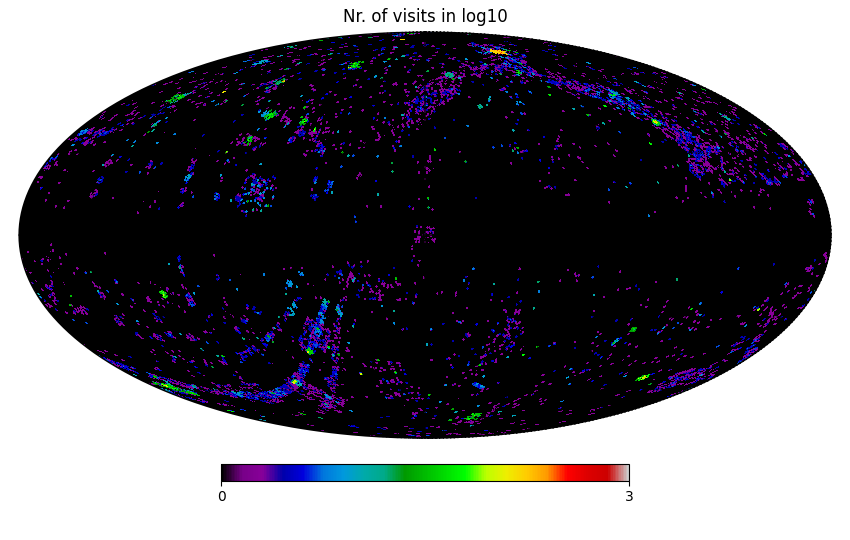

In [10]:
#Setup high res plotting data
nside_hres     = nside*16
npix_hres = hpy.nside2npix(nside_hres)
pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * uu.deg
print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
tt_sel["hvec"] = hpy.ang2vec(tt_sel["gall"],tt_sel["galb"],lonlat=True)

nr_visits_hres = np.zeros(npix_hres)  # empty map
GALEX_FOV = 0.5  # disc radius in deg

# fill map with coverage data
for vec in tt_sel["hvec"]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=vec, radius=np.radians(GALEX_FOV))
    nr_visits_hres[ipix_disc] += 1  # number of visits

#Plot
hpy.mollview(np.log10(nr_visits_hres+1e-3), title="Nr. of visits in log10",nest=False,cmap="nipy_spectral",min=0,max=3,xsize=4800)
hpy.graticule()

#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)